In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

import matplotlib.pyplot as plt
import json
from pathlib import Path

# Canonical results folder (repo root)
RESULTS_DIR = Path("..") / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("RESULTS_DIR:", RESULTS_DIR.resolve())



RESULTS_DIR: /workspaces/fake-news-dissertation/results


In [2]:
columns = [
    "id", "label", "statement", "subject", "speaker", "job_title",
    "state", "party",
    "barely_true_counts", "false_counts", "half_true_counts",
    "mostly_true_counts", "pants_on_fire_counts", "context"
]

train_df = pd.read_csv("../data/raw/train.tsv", sep="\t", header=None)
valid_df = pd.read_csv("../data/raw/valid.tsv", sep="\t", header=None)
test_df  = pd.read_csv("../data/raw/test.tsv", sep="\t", header=None)

train_df.columns = columns
valid_df.columns = columns
test_df.columns  = columns


In [3]:
X_train = train_df["statement"]
y_train = train_df["label"]

X_valid = valid_df["statement"]
y_valid = valid_df["label"]


In [4]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)


In [5]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_valid_tfidf)


In [6]:
print("Logistic Regression Accuracy:",
      accuracy_score(y_valid, y_pred_lr))

print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_valid, y_pred_lr))


Logistic Regression Accuracy: 0.21495327102803738

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

 barely-true       0.17      0.13      0.15       237
       false       0.25      0.31      0.28       263
   half-true       0.18      0.23      0.21       248
 mostly-true       0.25      0.25      0.25       251
  pants-fire       0.32      0.05      0.09       116
        true       0.19      0.22      0.21       169

    accuracy                           0.21      1284
   macro avg       0.23      0.20      0.20      1284
weighted avg       0.22      0.21      0.21      1284



In [7]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_valid_tfidf)


In [8]:
print("Naive Bayes Accuracy:",
      accuracy_score(y_valid, y_pred_nb))

print("\nClassification Report (Naive Bayes):\n")
print(classification_report(y_valid, y_pred_nb))


Naive Bayes Accuracy: 0.2336448598130841

Classification Report (Naive Bayes):

              precision    recall  f1-score   support

 barely-true       0.18      0.09      0.12       237
       false       0.27      0.33      0.30       263
   half-true       0.21      0.38      0.27       248
 mostly-true       0.26      0.30      0.28       251
  pants-fire       0.33      0.01      0.02       116
        true       0.20      0.12      0.15       169

    accuracy                           0.23      1284
   macro avg       0.24      0.21      0.19      1284
weighted avg       0.24      0.23      0.21      1284



Metrics summary: {'model': 'tfidf_logreg', 'split': 'validation', 'tfidf_ngram': '(1,1)', 'stop_words': 'english', 'max_features': 5000, 'class_weight': None, 'accuracy': 0.21495327102803738, 'macro_precision': 0.22730155958184264, 'macro_recall': 0.19937426791806, 'macro_f1': 0.19583751645282768, 'weighted_precision': 0.22124540637990556, 'weighted_recall': 0.21495327102803738, 'weighted_f1': 0.20764931818879773}


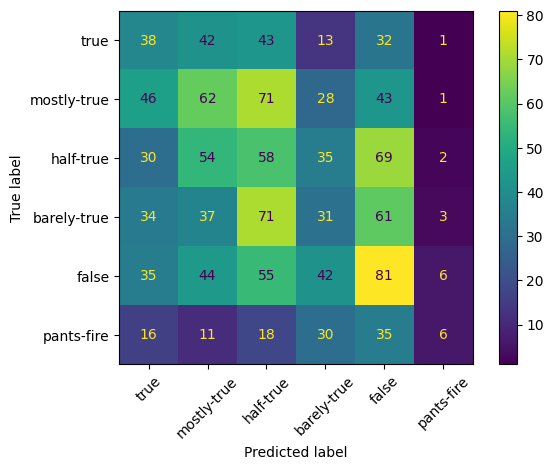

Saved files to: /workspaces/fake-news-dissertation/results


In [9]:
# === Week 3: Save baseline artefacts (LogReg on validation) ===

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Canonical results folder (repo root)
results_dir = Path("..") / "results"
results_dir.mkdir(parents=True, exist_ok=True)

# Fixed label order for consistency
label_order = ["true", "mostly-true", "half-true", "barely-true", "false", "pants-fire"]

# Core metrics (Logistic Regression)
acc = accuracy_score(y_valid, y_pred_lr)

prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_valid, y_pred_lr, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_valid, y_pred_lr, average="weighted", zero_division=0
)

metrics = {
    "model": "tfidf_logreg",
    "split": "validation",
    "tfidf_ngram": "(1,1)",
    "stop_words": "english",
    "max_features": 5000,
    "class_weight": None,
    "accuracy": float(acc),
    "macro_precision": float(prec_m),
    "macro_recall": float(rec_m),
    "macro_f1": float(f1_m),
    "weighted_precision": float(prec_w),
    "weighted_recall": float(rec_w),
    "weighted_f1": float(f1_w),
}

print("Metrics summary:", metrics)

# Confusion matrix (ordered labels)
cm = confusion_matrix(y_valid, y_pred_lr, labels=label_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()

# Save metrics + confusion matrix
(results_dir / "baseline_metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
pd.DataFrame(cm, index=label_order, columns=label_order).to_csv(results_dir / "confusion_matrix.csv")

# Save validation predictions for error analysis
pred_df = pd.DataFrame({
    "statement": X_valid,
    "true_label": y_valid,
    "pred_label": y_pred_lr
})
pred_df.to_csv(results_dir / "valid_predictions.csv", index=False)

print("Saved files to:", results_dir.resolve())


In [10]:
# === Variant A: TF-IDF (1,2) n-grams + LogReg ===
vectorizer_ng = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=5000,
    ngram_range=(1,2)
)

X_train_ng = vectorizer_ng.fit_transform(X_train)
X_valid_ng = vectorizer_ng.transform(X_valid)

log_reg_ng = LogisticRegression(max_iter=1000, random_state=42)
log_reg_ng.fit(X_train_ng, y_train)
y_pred_ng = log_reg_ng.predict(X_valid_ng)

acc = accuracy_score(y_valid, y_pred_ng)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_valid, y_pred_ng, average="macro", zero_division=0
)
p_w, r_w, f1_w, _ = precision_recall_fscore_support(
    y_valid, y_pred_ng, average="weighted", zero_division=0
)

metrics_ng = {
    "model": "logreg",
    "tfidf_ngram": "(1,2)",
    "stop_words": "english",
    "max_features": 5000,
    "class_weight": None,
    "accuracy": float(acc),
    "macro_precision": float(p_macro),
    "macro_recall": float(r_macro),
    "macro_f1": float(f1_macro),
    "weighted_f1": float(f1_w),
}

with open(RESULTS_DIR / "metrics_logreg_ngram12.json", "w", encoding="utf-8") as f:
    json.dump(metrics_ng, f, indent=2)

pd.DataFrame({
    "statement": X_valid,
    "true_label": y_valid,
    "pred_label": y_pred_ng
}).to_csv(RESULTS_DIR / "preds_logreg_ngram12.csv", index=False)

print(metrics_ng)


{'model': 'logreg', 'tfidf_ngram': '(1,2)', 'stop_words': 'english', 'max_features': 5000, 'class_weight': None, 'accuracy': 0.23286604361370716, 'macro_precision': 0.24741789301827774, 'macro_recall': 0.21814459285378043, 'macro_f1': 0.21774190039679983, 'weighted_f1': 0.22689324480910447}


In [11]:
# === Variant B: class_weight="balanced" + LogReg ===
vectorizer_bal = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=5000,
    ngram_range=(1,1)
)

X_train_bal = vectorizer_bal.fit_transform(X_train)
X_valid_bal = vectorizer_bal.transform(X_valid)

log_reg_bal = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg_bal.fit(X_train_bal, y_train)
y_pred_bal = log_reg_bal.predict(X_valid_bal)

acc = accuracy_score(y_valid, y_pred_bal)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_valid, y_pred_bal, average="macro", zero_division=0
)
p_w, r_w, f1_w, _ = precision_recall_fscore_support(
    y_valid, y_pred_bal, average="weighted", zero_division=0
)

metrics_bal = {
    "model": "logreg",
    "tfidf_ngram": "(1,1)",
    "stop_words": "english",
    "max_features": 5000,
    "class_weight": "balanced",
    "accuracy": float(acc),
    "macro_precision": float(p_macro),
    "macro_recall": float(r_macro),
    "macro_f1": float(f1_macro),
    "weighted_f1": float(f1_w),
}

with open(RESULTS_DIR / "metrics_logreg_balanced.json", "w", encoding="utf-8") as f:
    json.dump(metrics_bal, f, indent=2)

pd.DataFrame({
    "statement": X_valid,
    "true_label": y_valid,
    "pred_label": y_pred_bal
}).to_csv(RESULTS_DIR / "preds_logreg_balanced.csv", index=False)

print(metrics_bal)


{'model': 'logreg', 'tfidf_ngram': '(1,1)', 'stop_words': 'english', 'max_features': 5000, 'class_weight': 'balanced', 'accuracy': 0.22274143302180685, 'macro_precision': 0.2233770028495491, 'macro_recall': 0.23610767874297314, 'macro_f1': 0.22404142684003367, 'weighted_f1': 0.2212118375712104}


In [12]:
# === Week 3 deliverable: baseline_variants.csv ===
import json

def load_metrics(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

rows = []
for fn in [
    "metrics_logreg_unigram.json",
    "metrics_logreg_ngram12.json",
    "metrics_logreg_balanced.json"
]:
    p = RESULTS_DIR / fn
    if p.exists():
        rows.append(load_metrics(p))

variants_df = pd.DataFrame(rows)[[
    "model","tfidf_ngram","class_weight",
    "accuracy","macro_f1","weighted_f1",
    "macro_precision","macro_recall"
]].sort_values("macro_f1", ascending=False)

variants_df.to_csv(RESULTS_DIR / "baseline_variants.csv", index=False)
variants_df


,model,tfidf_ngram,class_weight,accuracy,macro_f1,weighted_f1,macro_precision,macro_recall
1,logreg,"(1,1)",balanced,0.222741,0.224041,0.221212,0.223377,0.236108
0,logreg,"(1,2)",NaN,0.232866,0.217742,0.226893,0.247418,0.218145


In [13]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

RESULTS_DIR = Path("..") / "results"

# --- Load baseline metrics JSON ---
baseline_metrics_path = RESULTS_DIR / "baseline_metrics.json"
with open(baseline_metrics_path, "r", encoding="utf-8") as f:
    bm = json.load(f)

# --- Recompute key metrics from valid_predictions.csv (source of truth) ---
preds_path = RESULTS_DIR / "valid_predictions.csv"
preds = pd.read_csv(preds_path)

y_true = preds["true_label"].astype(str).to_numpy()
y_pred = preds["pred_label"].astype(str).to_numpy()

labels = sorted(set(y_true) | set(y_pred))
idx = {lab: i for i, lab in enumerate(labels)}
cm = np.zeros((len(labels), len(labels)), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[idx[t], idx[p]] += 1

acc = np.trace(cm) / cm.sum() if cm.sum() else 0.0

tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp

precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp) != 0)
recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0)
f1        = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(tp, dtype=float), where=(precision + recall) != 0)

support = cm.sum(axis=1)
macro_precision = float(np.mean(precision))
macro_recall    = float(np.mean(recall))
macro_f1        = float(np.mean(f1))
weighted_f1     = float(np.average(f1, weights=support)) if support.sum() else 0.0

# --- Build baseline row (match your variants table columns) ---
baseline_row = {
    "model": bm.get("model", "tfidf_logreg"),
    "tfidf_ngram": bm.get("tfidf_ngram", "(1,1)"),
    "class_weight": bm.get("class_weight", None),
    "accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "macro_precision": float(macro_precision),
    "macro_recall": float(macro_recall),
}

# --- Load existing variants table ---
variants_path = RESULTS_DIR / "baseline_variants.csv"
variants_df = pd.read_csv(variants_path)

# If the baseline row already exists (same ngram + class_weight), don't duplicate
def norm(x):
    if pd.isna(x):
        return ""
    return str(x).strip().lower()

baseline_key = (norm(baseline_row["tfidf_ngram"]), norm(baseline_row["class_weight"]))

existing_keys = set(
    (norm(r["tfidf_ngram"]), norm(r["class_weight"]))
    for _, r in variants_df.iterrows()
)

if baseline_key not in existing_keys:
    variants_df = pd.concat([pd.DataFrame([baseline_row]), variants_df], ignore_index=True)

# Sort by macro_f1 (best at top)
variants_df = variants_df.sort_values("macro_f1", ascending=False)

# Save back
variants_df.to_csv(variants_path, index=False)
print("Updated:", variants_path.resolve())
variants_df


Updated: /workspaces/fake-news-dissertation/results/baseline_variants.csv


,model,tfidf_ngram,class_weight,accuracy,macro_f1,weighted_f1,macro_precision,macro_recall
1,logreg,"(1,1)",balanced,0.222741,0.224041,0.221212,0.223377,0.236108
2,logreg,"(1,2)",NaN,0.232866,0.217742,0.226893,0.247418,0.218145
0,tfidf_logreg,"(1,1)",None,0.214953,0.195838,0.207649,0.227302,0.199374
